# Relabel a CSV file

This notebook is used to relabel a CSV file of gestures. When gesture data gets recorded, labels are automatically added at regular intervals, but the actual timing of when the user's hands move might not align perfectly with those automatically added labels. This notebook can be run and will visualise the data in the CSV file along with the labels. The CSV file can then be edited externally and reloaded in this notebook. In this way, the labels can (slowly) be moved around until they align with the gestures.

In [2]:
# Change directory to keep paths consistent
%cd /Users/brk/projects/masters/SU/ergo/src

/Users/brk/projects/masters/SU/ergo/src


In [3]:
# Imports and setup
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
import pandas as pd
import numpy as np
import models
import vis
import common
import read
import tensorflow as tf
from tensorflow import keras
from keras import layers
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tqdm
import yaml
import glob
import re

# Visualise a CSV file of data

In [8]:
# %%script false --no-raise-error
filename = "../gesture_data/saved_from_cli_2023-10-04T14:04:31.csv"
const: common.ConstantsDict = common.read_constants('../src/constants.yaml')
names = ['datetime', 'gesture'] + list(const["sensors"].values())

interactive(children=(IntSlider(value=0, description='start', max=14185, step=20), Output()), _dom_classes=('w…

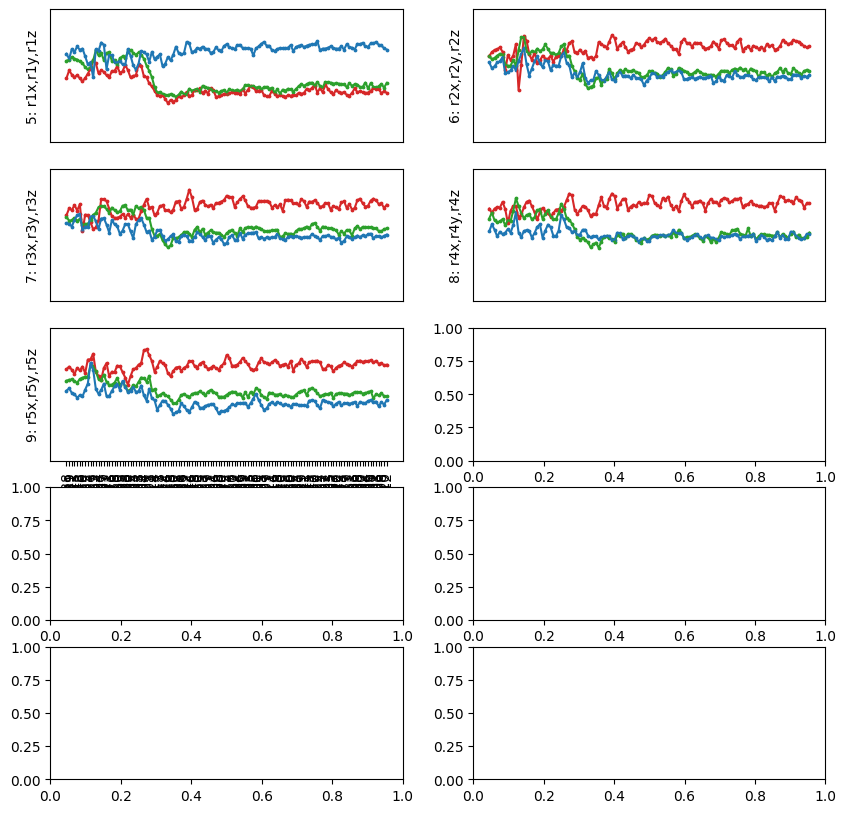

In [13]:
# %%script false --no-raise-error
@interact(start=(0, 14185, 20))
def fn(start=0):
    duration = 120
    t0 = start
    t1 = start + duration
    df = pd.read_csv(filename, header=None, names=names)
    values = df.loc[t0:t1, names[2:]].values
    labels = df.loc[t0:t1, 'gesture'].values
    datetimes = df.loc[t0:t1, 'datetime'].values
    ylim = values.min()*0.9, values.max()*1.1
    mid = (ylim[1] - ylim[0]) * 0.5
    # NOTE: this only visualises the right hand
    fig, axs = plt.subplots(5, 2, figsize=(10, 10))
    for i, ax in enumerate(axs.flatten(), 5):
        ax.plot(values[:, i*3+0], c='tab:red')
        ax.plot(values[:, i*3+1], c='tab:green')
        ax.plot(values[:, i*3+2], c='tab:blue')

        ax.scatter(range(values.shape[0]), values[:, i*3+0], c='tab:red', s=3)
        ax.scatter(range(values.shape[0]), values[:, i*3+1], c='tab:green', s=3)
        ax.scatter(range(values.shape[0]), values[:, i*3+2], c='tab:blue', s=3)
        for x, label in filter(lambda l: l[1] != 'gesture0255' and pd.notna(l[1]), enumerate(labels)):
            txt = label.replace('gesture00', 'g') if type(label) is str else label
            ax.text(x, ylim[1], txt, rotation=90, va='top')
        ax.set(
            yticks=[],
            xticks=[],
            ylim=ylim,
            ylabel=f'{i}: ' + ",".join(names[2:][i*3:i*3+3]),
        )
        if i in (4, 9):
            xticklabels = [(None if labels[i] == 'gesture0255' else dt[11:-4]) for i, dt in enumerate(datetimes)]
            ax.set_xticks(range(len(xticklabels)))
            ax.set_xticklabels(xticklabels, rotation=90)
    plt.tight_layout()

# Cache an `npz` file of the observations

The CSV files are the raw data source, but they're pretty slow to load up and pre-process in to windowed observations. Pre-calculate the windowed data as numpy arrays and split them into train/validation and testing datasets, to be saved as `npz` compressed arrays.

In [ ]:
delay = 10
window_size = 20

print("1. Read in the new data as (X, y, dt) arrays")
df_n = read.read_data('../gesture_data/new_data/', constants_path='../src/constants.yaml')

print("2. Read in all the old data as (X, y, dt) arrays")
df_o = read.read_data(
    '../gesture_data/train/', 
    offsets_path='../offsets.csv',
    constants_path='../src/constants.yaml',
)
print("3. Combine the old and new data, and split into windows")
combined_df = pd.concat((df_o, df_n))
X, y_str, dt = common.make_windows(
    combined_df,
    window_size,
    constants_path='../src/constants.yaml',
    pbar=tqdm.tqdm(total=len(combined_df), desc="Making windows")
)

print("4. Convert the string labels to integer labels")
g2i, _i2g = common.make_gestures_and_indices(y_str)
y = g2i(y_str)

print(f"5. Calculate the delay of {delay}")
if delay != 0:
    print("  5a. Get a list of CSV paths")
    csv_paths = sorted([
        path.split('/')[-1].replace('.csv', '')
        for path in
            glob.glob('../gesture_data/train/*.csv') + glob.glob('../gesture_data/new_data/*.csv')
    ])

    print("  5b. Use the CSV paths to reverse-engineer the file for each observation")
    # Reverse-engineer which data observations came from which files.
    # We have to do this because we can't have a delay going across files
    curr_csv_i = 0
    files = np.full(dt.shape, -1)
    for i, d in tqdm.tqdm(enumerate(dt), total=dt.shape[0]):
        if curr_csv_i + 1 < len(csv_paths):
            next_csv_time = pd.to_datetime(csv_paths[curr_csv_i + 1])
            if next_csv_time < d:
                curr_csv_i += 1
        files[i] = curr_csv_i
    assert not (files == -1).any()
    
    print(f"  5c. Add in an {delay} time step delay")
    # Within each file, add a delay of XXX time steps
    y_delayed = np.copy(y)
    for file_idx in np.unique(files):
    #     print(file_idx)
        mask = (files == file_idx)
        indices = np.nonzero(mask)[0]
    #     print(indices)
    #     print(indices[delay:])
    #     print(indices[:-delay])
        # Delay the data
        y_delayed[indices[delay:]] = y_delayed[indices[:-delay]]
        # add some padding/filler to the front
        y_delayed[indices[:delay]] = np.full((delay,), 50)
    print(delay, np.nonzero(y != 50)[0][:10])
    print(delay, np.nonzero(y_delayed != 50)[0][:10])
    y = y_delayed

    
# NOTE: There aren't actually enough observations to limit. The least represented class
# has ~80 observations and the most represented non-255 class has 160, so it doens't
# make sense to halve the data for some classes.
print("6. Skipping data limiting...")
# print("6. Limit data to just the first 200 observations of each non-255 gesture")
# # This is done so that we've got consistent class sizes and don't have to mess around
# # with class weightings too much
# idxs = np.where(y == 50)[0]
# for yi in np.unique(y):
#     if yi == 50:
#         continue
#     idxs = np.append(np.where(y == yi)[0][:200], idxs)
# X = X[idxs]
# y = y[idxs]
# dt = dt[idxs]

print("7. Save the data")
X_trn, X_tst, y_trn, y_tst, dt_trn, dt_tst = sklearn.model_selection.train_test_split(
    X, y, dt, stratify=y, test_size=0.25, random_state=42
)
trn_path = f"../gesture_data/trn_{window_size}_{delay}.npz"
np.savez(
    trn_path, X_trn=X_trn, y_trn=y_trn, dt_trn=dt_trn
)
np.savez(
    f"../gesture_data/tst_{window_size}_{delay}.npz", X_tst=X_tst, y_tst=y_tst, dt_tst=dt_tst
)
print(f"Saved to {trn_path}")